In [1]:
import torch
!pip install segment-anything
from segment_anything import sam_model_registry
import matplotlib.pyplot as plt

In [2]:
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT = "sam_vit_h_4b8939.pth"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT)
sam.to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [4]:
def ShowImage(img):
  plt.imshow(img)
  plt.axis("off")
  plt.show()

In [6]:
import cv2 as cv
from segment_anything import SamAutomaticMaskGenerator
!pip install supervision
import supervision as sv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 13.7 MB/s eta 0:00:00


# Finished Setup

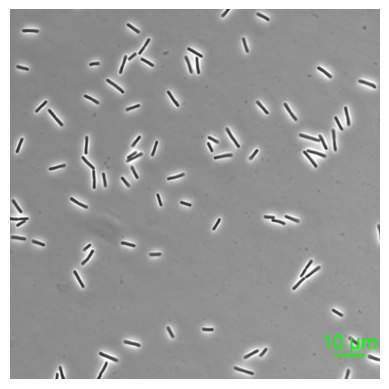

In [48]:
img_path = "/content/images/20240917_delta6_5.tif"
img_bgr = cv.imread(img_path)
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
img_rgb = cv.GaussianBlur(img_rgb, (5, 5), 0)

ShowImage(img_rgb)

# PreProcessing

# SAM Segmentation

## Original


In [49]:
mask_generator = SamAutomaticMaskGenerator(sam)
result = mask_generator.generate(img_rgb)

In [50]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(result)

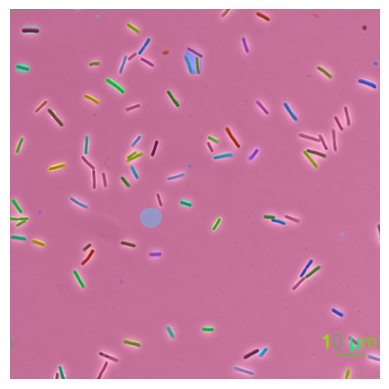

In [51]:
img_annotated = mask_annotator.annotate(img_bgr, detections)

ShowImage(img_annotated)

In [52]:
SaveThresholdImages(img_bgr, img_annotated, '')

## Multiple Images


In [66]:
def SaveSegmentedImages(image1, image2, title):

  fig, axes = plt.subplots(1,2, figsize=(10,5))

  axes[0].imshow(image1)
  axes[0].set_title(f"Original")
  axes[0].axis("off")

  axes[1].imshow(image2)
  axes[1].set_title("Segmented Image")
  axes[1].axis("off")

  plt.tight_layout()
  plt.savefig(f'{title}.png')

  plt.close()

In [61]:
image_paths = [
    "/content/images/20240917_delta6_100x_1.tif",
    "/content/images/20240917_delta6_100x_2.tif",
    "/content/images/20240917_delta6_100x_3.tif",
    "/content/images/20240917_delta6_100x_4.tif",
    "/content/images/20240917_delta6_5.tif"
    ]

In [67]:
def GetImage(img_path):
  img_bgr = cv.imread(img_path)
  img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
  img_rgb = cv.GaussianBlur(img_rgb, (5, 5), 0)

  return img_rgb

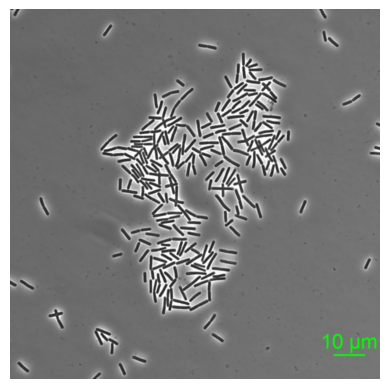

In [68]:
test = GetImage(image_paths[0])
ShowImage(test)

In [69]:
def SegmentImage(img, sam):
  mask_generator = SamAutomaticMaskGenerator(sam)
  result = mask_generator.generate(img)

  mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
  detections = sv.Detections.from_sam(result)

  img_annotated = mask_annotator.annotate(img, detections)
  return img_annotated

In [73]:
for img_path in image_paths:
  img_original = GetImage(img_path)
  img_copy = img_original.copy()
  img_segmented = SegmentImage(img_original, sam)

  start_idx = img_path.rfind("delta")
  end_idx = img_path.rfind(".tif")

  img_name = img_path[start_idx:end_idx]

  SaveSegmentedImages(img_copy, img_segmented, f"segmented_{img_name}.png")

## different thresholds


In [74]:
def SaveThresholdImages(image1, image2, threshold):

  fig, axes = plt.subplots(1,2, figsize=(10,5))

  axes[0].imshow(image1)
  axes[0].set_title(f"Threshold: {threshold}")
  axes[0].axis("off")

  axes[1].imshow(image2)
  axes[1].set_title("Segmented Image")
  axes[1].axis("off")

  plt.tight_layout()
  plt.savefig(f'segment_threshold{threshold}.png')

  plt.close()

In [78]:
def SegmentImage(img, sam):
  mask_generator = SamAutomaticMaskGenerator(sam)
  result = mask_generator.generate(img)

  mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
  detections = sv.Detections.from_sam(result)

  img_annotated = mask_annotator.annotate(img, detections)
  return img_annotated, detections

In [76]:
def PreProcessImage(img, threshold):
  blurred = cv.GaussianBlur(img, (5, 5), 0)
  _, img_thresh = cv.threshold(blurred, threshold, 255, cv.THRESH_BINARY)
  return img_thresh

In [83]:
threshold_values = [80, 90, 100, 110, 120]
for threshold in threshold_values:
  img_thresh = PreProcessImage(img_rgb, threshold)
  img_copy = img_thresh.copy()
  img_annotated, detections = SegmentImage(img_thresh, sam)

  img_segmented = mask_annotator.annotate(img_thresh, detections)

  SaveThresholdImages(img_rgb, img_segmented, threshold)

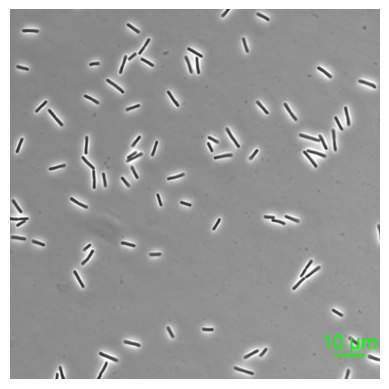

In [82]:
ShowImage(img_rgb)